In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import collections
import random

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

from collections import Counter, defaultdict
from operator import itemgetter
from tqdm import tqdm

Loading the adjacency matrix and the sampled data

In [2]:
adjacency_matrix = np.load('adjacency_matrix.npy')

data_recipe = pd.read_json('processed_data.json').reset_index(drop=True)

In [3]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,[Position rack in center of oven; preheat to 3...,27,2004-08-20 04:00:00,"[Cake, Food Processor, Mixer, Cheese, Dairy, E...",479,7,3.750,"Christmas Cranberry, Pear and Walnut Torte wit...","[orange, puree, cheese-orange, egg, frosting, ...",204
1,[Butter 11x7x2-inch glass baking dish. Sauté s...,46,2004-08-20 04:00:00,"[Onion, Pepper, Pork, Breakfast, Sauté, Parmes...",606,22,3.125,"Breakfast Polenta with Sausage, Onion and Peppers","[sausage, casing, bell, onion, cornmeal, butte...",968
2,"[Stir together butter, horseradish, dill, shal...",100,2007-05-17 19:43:26,"[Fish, Herb, Backyard BBQ, Dinner, Horseradish...",1305,92,4.375,Grilled Boneless Salmon Steaks with Horseradis...,"[horseradish, shallot, oil, string, salmon, bu...",923
3,[Cook bacon in a deep 12-inch heavy skillet ov...,71,2004-08-20 04:00:00,"[Chicken, Garlic, Braise, Vinegar, Bacon, Fall...",1086,81,3.750,"Braised Chicken with Shallots, Garlic, and Bal...","[shallot, slice, piece, head, strip, 1/2-lb, b...",485
4,[Cut off all peel and white pith from 3 blood ...,0,2007-10-02 19:13:35,"[Sauce, Food Processor, Side, No-Cook, Christm...",255,2,4.375,Cranberry and Blood Orange Relish,"[blood, orange, cranberry, sugar]",2


Plotting the adjacency matrix to see sparsity pattern

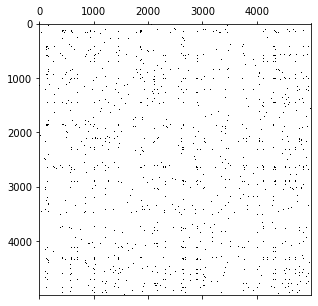

In [4]:
plt.figure(figsize=(5,5))
plt.spy(adjacency_matrix)
plt.show()

In [5]:
def describe_graph(G):
    """
    Helper function for printing various graph properties.
    
    Parameters
    ----------
    
    G: NetworkX graph object
        Graph
    """
    print(nx.info(G))
    if nx.is_connected(G):
        print("Average shortest path length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

Let's create a graph object from our adjacency matrix

In [6]:
graph = nx.from_numpy_array(adjacency_matrix)

In [7]:
describe_graph(graph)

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 230352
Average degree:  92.1408
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0184
Global clustering coefficient aka Transitivity: 0.3363


Creating dictionaries which will map nodes to the corresponding dish names and vice versa

In [8]:
node_label_mapping = dict(zip(range(5000), data_recipe.title))
label_node_mapping = dict(zip(data_recipe.title,range(5000)))

Now, let's add attributes to our graph's nodes

In [9]:
nx.set_node_attributes(graph, data_recipe['protein'].to_dict(), 'protein')
nx.set_node_attributes(graph, data_recipe['fat'].to_dict(), 'fat')
nx.set_node_attributes(graph, data_recipe['sodium'].to_dict(), 'sodium')
nx.set_node_attributes(graph, data_recipe['calories'].to_dict(), 'calories')
nx.set_node_attributes(graph, data_recipe['rating'].to_dict(), 'rating')

An example of a node with its corresponding dish title

In [10]:
print(node_label_mapping[0])
print(graph.node[0])

Christmas Cranberry, Pear and Walnut Torte with Cream Cheese-Orange Frosting
{'protein': 7, 'fat': 27, 'sodium': 204, 'calories': 479, 'rating': 3.75}


In [14]:
def visualize_graph(G, signal, with_labels=False, k=None, alpha=1.0, node_shape='o'):
    """
    Helper function for visualizing signal on the graph.

    Parameters
    ----------

    G: NetworkX graph object
        Graph
    
    signal: string
        Node attribute to be used as a graph signal
    
    with_labels: boolean
        Node label
    
    k: float
        Optimal distance between nodes.  If None the distance is set to
        1/sqrt(n) where n is the number of nodes.  Increase this value
        to move nodes farther apart.
        
    alpha: float
        The edge transparency
    
    node_shape: string
        The shape of the node.  Specification is as matplotlib.scatter
        marker, one of 'so^>v<dph8'
    """
    plt.figure(figsize=(15,8))
    plt.title(signal + ' as a signal on the graph')
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[G.nodes[n][signal] for n in G.nodes()], node_shape=node_shape)
    plt.colorbar(nc)
    plt.axis('off')

Having the graph ready, let's visualize our features/attributes (e.g. rating, protein) as graph signals

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


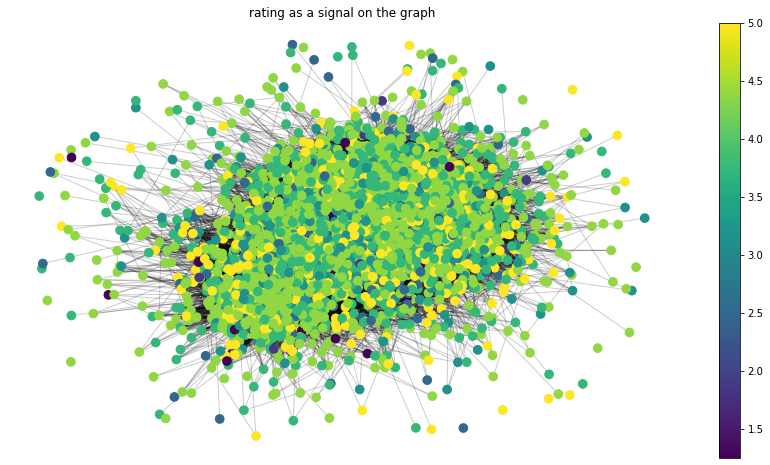

In [15]:
visualize_graph(graph,'rating', k=0.1, alpha=0.2, node_shape='.')

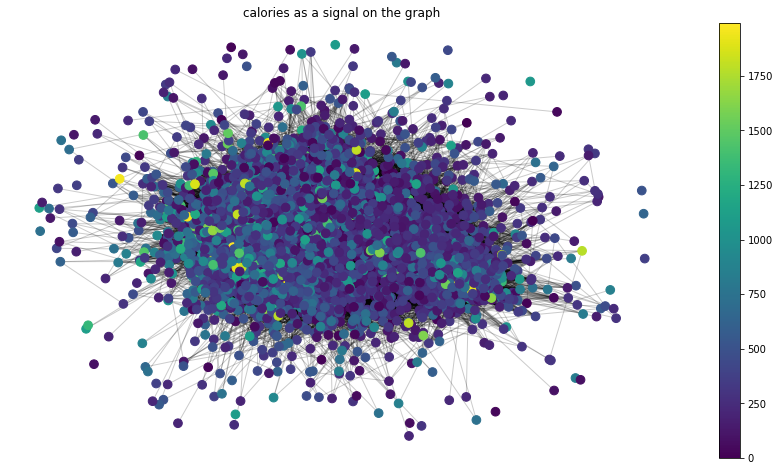

In [16]:
visualize_graph(graph,'calories', k=0.1, alpha=0.2, node_shape='.')

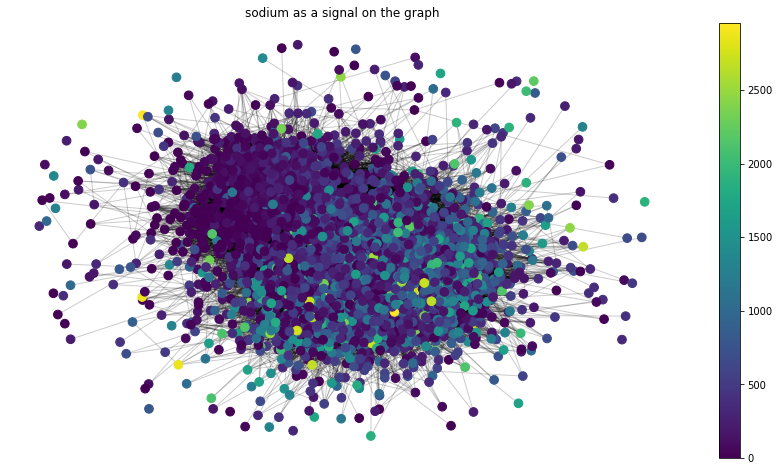

In [17]:
visualize_graph(graph,'sodium', k=0.1, alpha=0.2, node_shape='.')

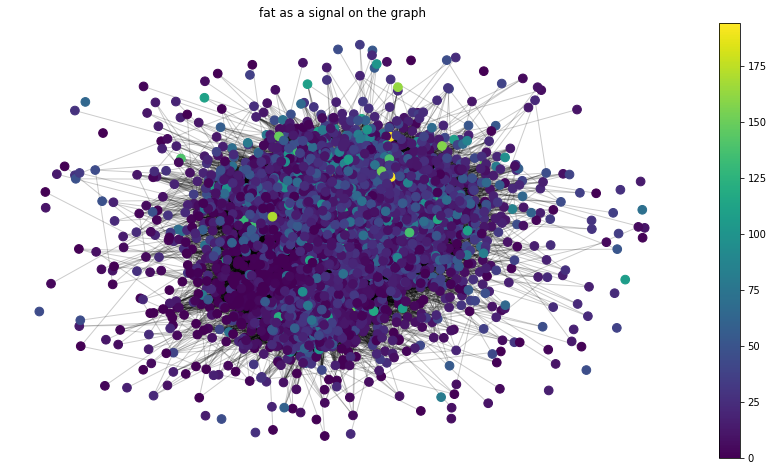

In [18]:
visualize_graph(graph,'fat', k=0.1, alpha=0.2, node_shape='.')

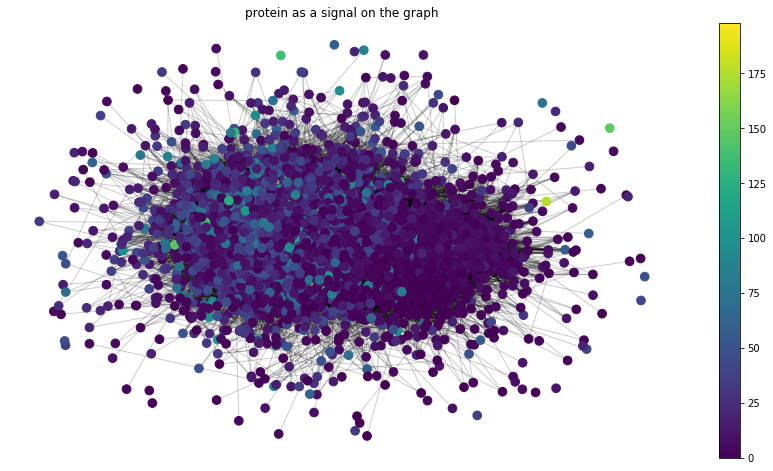

In [19]:
visualize_graph(graph,'protein', k=0.1, alpha=0.2, node_shape='.')

One of the interesting questions that one may think of is the following: **_Do similar recipes tend to have similar ratings?_**

Given our graph, to answer this question we can simply calculate attribute assortativity coefficient for 'rating', which measures the similarity of connections in the graph with respect to the 'rating' attribute.

In [20]:
nx.attribute_assortativity_coefficient(graph, 'rating')

0.01129789184202755

As we can see the number is quite small indicating that in general similar recipes do not have similar ratings.

### Community detection

Given our graph, it is extremely interesting to investigate the different clusters and their properties it contains. For this purpose we are going to use the **_Louvain method_**, which is one of the most famous algorithms for commuity detection.

In [21]:
partition = community_louvain.best_partition(graph, random_state=7) # fixing random_state with some random number
# to have deterministic results, i.e. have the same output each time

In [22]:
print('Total number of clusters found: {}'.format(max(partition.values())+1))

Total number of clusters found: 33


Let's add as a node attribute the cluster label obtained from the partition by the Louvain method

In [23]:
nx.set_node_attributes(graph, partition, 'cluster')

Now, let's visualize the different clusters

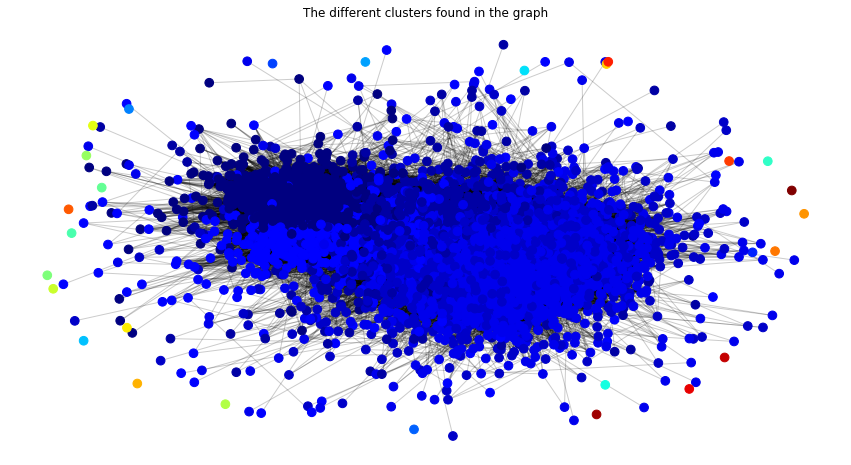

In [24]:
plt.figure(figsize=(15,8))
plt.title('The different clusters found in the graph')
pos = nx.spring_layout(graph,k=0.1)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes(), node_color=[graph.nodes[n]['cluster'] for n in graph.nodes()], 
                            with_labels=False, node_shape='.', cmap=plt.cm.jet)
plt.axis('off')
plt.show()

Let's print the number of nodes in each cluster.

In [25]:
Counter(partition.values())

Counter({0: 1017,
         1: 499,
         2: 1188,
         3: 1851,
         4: 417,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1})

Let's take the big clusters and investigate the properties shared within each individual cluster.

In [26]:
# Take all the nodes that belong to the 0th, 1st, 2nd, 3rd and 4th clusters respectively
cluster_0 = [k for k in graph.nodes if partition[k] == 0]
cluster_1 = [k for k in graph.nodes if partition[k] == 1]
cluster_2 = [k for k in graph.nodes if partition[k] == 2]
cluster_3 = [k for k in graph.nodes if partition[k] == 3]
cluster_4 = [k for k in graph.nodes if partition[k] == 4]

To help us analyze the clusters, we will take a look at the category labels that are occuring frequently in each cluster.

In [27]:
# Remove some labels which do not give relevant information about the clusters
redundent_categories = ['Peanut Free', 'Soy Free', 'Kosher', 'Bon Appétit',
    'Tree Nut Free', 'Kidney Friendly', 'Wheat/Gluten-Free', 'Quick & Easy', 'Dairy Free', 'Fall', 'No Sugar Added']

# Find 10 most occuring categories for each cluster
def print_top_10_categories(cluster):
    categories = []
    for elem in data_recipe.iloc[cluster].categories:
        categories.extend(elem)
        
    categories = [elem for elem in categories if elem not in redundent_categories]

    count = collections.Counter(categories)

    print(sorted(count, key=count.get, reverse=True)[:10])   

print_top_10_categories(cluster_0)
print_top_10_categories(cluster_1)
print_top_10_categories(cluster_2)
print_top_10_categories(cluster_3)
print_top_10_categories(cluster_4)

['Dessert', 'Bake', 'Vegetarian', 'Pescatarian', 'Gourmet', 'Egg', 'Milk/Cream', 'Fruit', 'Chocolate', 'Dairy']
['Vegetarian', 'Gourmet', 'Side', 'Bake', 'Pescatarian', 'Potato', 'Winter', 'Milk/Cream', 'Sugar Conscious', 'Cheese']
['Gourmet', 'Summer', 'Vegetarian', 'Pescatarian', 'Dinner', 'Sugar Conscious', 'Chicken', 'Herb', 'Sauté', 'Side']
['Gourmet', 'Vegetarian', 'Pescatarian', 'Side', 'Onion', 'Tomato', 'Summer', 'Dinner', 'Winter', 'Sauté']
['Vegetarian', 'Gourmet', 'Summer', 'Pescatarian', 'Dessert', 'Drink', 'Alcoholic', 'Fruit', 'Vegan', 'Cocktail Party']


In [32]:
for each in random.sample(cluster_0, 20):
    print(node_label_mapping[each])

Tarte Tatin
Lime Mousse with Lime-Vanilla Syrup
Hannah's Peanut Butter and White Chocolate Candies
Christmas Croissant Pudding with Sour Cream and Brown Sugar Sauce
Whole Grain-Buttermilk Pancakes
Apricot-Sour Cream Scones
Cherry-Vanilla Tea Cake with Vanilla Sugar
Vanilla Ice Cream and Ginger Molasses Cookie Sandwiches
Tropical Fruit Fantasy
Pecan Shortbread Cookies
Chocolate, Walnut and Prune Fudge Torte
Sweet-and-Sour Cherry Turnovers with Goat Cheese Cream
Snow Eggs with Pistachio Custard and Chocolate Drizzle
Pecan Pumpkin Pie
Gingered Lemon Almond Squares
Thick Apple Pancakes with Raspberry Sauce
Sour Cream Tart with Santa Rosa Plum Compote
Pineapple Macadamia Nut Meringue Pies
Apple-Raisin Bread Pudding
Hot Molasses Milk Punch


Cluster_0: As we can notice, this cluster is mainly comprised of deserts (e.g. cakes, chocolates, ice-cream, etc.). In addition, some of the most occuring categories in this cluster include 'desert', 'bake' and 'chocolate'.

In [33]:
for each in random.sample(cluster_1, 20):
    print(node_label_mapping[each])

Spicy Shrimp Rémoulade on Molasses-Buttered Toast
Braised Belgian Endive Gratin
Goat Cheese with Grilled Eggplant and Roasted Peppers on Olive Bread
Root Vegetable Cobbler with Chive Biscuit Topping
Onion and Bacon Tart
Parmesan Sauce
Roasted Mushrooms Stuffed with Feta, Spinach, and Bacon
Filets Mignons with Mushroom Sauce
Baked Cheese Grits
Mini Pizzas
Lettuce Soup
Baked Eggs with Spinach
Mashed Potatoes with Kale
Cauliflower and Caramelized Onion Tart
Crispy Skate with Cauliflower, Bacon, Capers, and Croutons
Creamed Oysters and Mushrooms on Toast
Potato Gratin with Goat Cheese and Garlic
Sauteed Mushrooms with Melted Stilton
Walnut Bread
Cod Chowder with Saffron and Fingerling Potatoes


Cluster_1: We notice that this cluster contains mainly simple dishes which usually do not contain meat/chicken. 'Vegetarian' and 'Pescaterian' are for instance in the frequent categories' list. The recipes are mainly appetizers, sides and vegetarian simple dishes. Finally, note that a lot of dishes in this list have potato and cheese as common ingredients which also appear in the top 10 most occuring categories. 

In [34]:
for each in random.sample(cluster_2, 20):
    print(node_label_mapping[each])

Chicken Curry Soup with Coconut and Lime
Crab Cakes with Herb Salad
Chilled Avocado Soup
Charred Sugar Snap Peas with Buttermilk Aioli
Miso-Ginger Consommé
Pineapple Pork Chops
Maple-Barbecued Chicken
Zucchini Melon Salad
Perciatelli with Shrimp and Garlic Breadcrumbs
Grilled Turmeric and Lemongrass Chicken Wings
Cauliflower and Chickpea Curry
Mixed Vegetables with Coconut Sauce (Aviyal)
Tadka Dhal
Ginger-Cilantro Chutney
Nicaraguan-Style Steak
Pancetta-Wrapped Chicken with Cabbage
Poached Oysters in Fennel-Saffron Soup
Celery, Radish, and Olive Salad
Bok Choy with Fried Shallots
Halibut in Pernod Broth with Fennel and Asparagus


Cluster_2: This cluster contains many Spanish and Latin American cuisine dishes, for instance fajitas, guacamole, ceviche, Tacos, santa fe salad, steak with chimichurri Sauce... These dishes contain ingredients such as: avocado, bell pepper, jalapeño and beans. Also, many of the dishes contain chicken and the majority are not vegetarian and contain meat(chicken, beef,fish). 

In [35]:
for each in random.sample(cluster_3, 20):
    print(node_label_mapping[each])

Sausage Cheese Grits
Shrimp Gazpacho with Basil Croutons
Spanish-Style Chicken with Saffron Rice (Arroz con Pollo)
Fish Soup with Tomatoes and Red Pepper-Garlic Sauce
Black-Eyed Pea and Bacon Salad with Mustard Vinaigrette
Lamb and Shiitake Stew with Tomato-Chianti Sauce
Pork Stew with Olives and Green Beans
New England Sausage Stuffing with Maple Corn Bread
Chinese Broccoli with Crabmeat
Herbed Balsamic Chicken with Blue Cheese
Beet and Arugula Salad
Green Salad with Goat Cheese, Artichoke Hearts and Migas
Fresh-from-the-Garden Tomato Aspic
Grilled Pork Chops with Classic Barbecue Sauce
Grilled Ground Lamb Kebabs with Fresh Hot-Pepper Paste
Melon and Prosciutto Risotto
Mussels alla Diavola
Bulgur with Onion, Tomato, and Feta
Roast Beef, Red Pepper, Spinach, and Feta Sandwiches with Tahini Dressing
Lemon-Pepper Salt Rub


Cluster_3: This cluster consists of a mixture of European cuisine (French, Italian...) and Asian cuisine. For instance we could find  dishes such as: Duck Liver Pâté, Duck Breast and Frisée Salad, Fettuccine, Greek salad and dishes such as: Asian Noodles, Asian-Style Flank Steak, Coconut-Curry, etc.

In [36]:
for each in random.sample(cluster_4, 20):
     print(node_label_mapping[each])

Root Vegetable Gratin
Zested Carrot Zucchini Julienne
Cantaloupe Aqua Fresca with Beet Swirl
Blood Orange–Chia Pudding
Red Grape Granita
Strawberries & Cream Frappé
Earl Grey Rum Punch
Wild Rice and Chive Bâtardes
Caramel-Orange Sauce
Peach Royale
Pears Poached in Red Wine, Cardamom and Orange
Spiced Cranberry Sauce with Zinfandel
Coconut Marshmallows
Strawberry-Banana Smoothie
Hot Tea Punch
Tropical Fruit Smoothie
Worcestershire and Orange-Glazed Baby Back Ribs
Homemade Ginger Ale
Passion-Fruit Fool
Raspberry and Thyme Hot Toddy Punch


Cluster_4: This last cluster contains mainly drinks, sorbets and ice creams. Relevant categories found in this cluster are 'Alcoholic', 'drink' or 'Cocktail Party', which reflect very well the recipes found in this cluster. 

### Simple recommender system based on KNN

In [37]:
def get_top_n_recs(dish_list, k, n):
    """
    Give top-n recommendations given a list of dishes.

    Parameters
    ----------

    dish_list: list
        List of dish names
        
    n: int
        Number of recommendations to show
    
    k: int 
        Number of neighbors to use
    """
    
    dish_list = [label_node_mapping[each] for each in dish_list]
    
    d = {elem: graph.node[elem]['rating'] for elem in dish_list}
    k_neighbours = [each[0] for each in sorted(d.items(), key=itemgetter(1), reverse=True)[:k]]
    candidates = defaultdict(float)
    
    for each in k_neighbours:
        for i, elem in enumerate(adjacency_matrix[each]):
            candidates[i]+=elem

    print('The top {} recommendations are the following:'.format(n))
    count = 1
    for index, score in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        print(node_label_mapping[index])
        if count >= n:
            break
        count += 1

In [38]:
# This list includes are deserts, so we expect to get recommendations that are also deserts (e.g. cake, ice-cream)
dish_list = ['Chocolate, Cherry and Marsala Cassata', 'Ginger Pudding',
             'Trifle with Strawberries and Caramel-Coated Bananas', 'Thin Apple Tarts',
             'Shortbread Cookies', 'Burnt-Caramel Custards', 'Peach White-Wine Sangria']

get_top_n_recs(dish_list,k=5,n=5)

The top 5 recommendations are the following:
Sour Cream Ice Cream
Raspberry and Brown Sugar Custard Tart
Butter Pie Crust Dough
Burnt Caramel Ice Cream
Nectarine Lime Curd Tart with a Brown-Sugar Crust


As we can see the recommendations are quite adequate.

In [39]:
# This list includes drinks, so we expect to get recommendations that are drinks
dish_list = ['Crushed-Mint Lemonade','Ginger-Honey Lemonade','Papaya Smoothie',
            'Oranges with Pomegranate Molasses and Honey','Pine Nut Brittle','Sweet Avocado Mousse',
            'Gimlet','Campari Citrus Cooler','Tangerine Granita']

get_top_n_recs(dish_list,k=5,n=5)

The top 5 recommendations are the following:
Iced Vodka with Cucumber, Lemon, and Mint
Florida Punch
Iced Mint Tea
Butter Pie Crust Dough
Sidecar


As we can see the recommendations are again quite good.

Let's see what recommendations we get if we include both drinks and deserts.

In [40]:
dish_list = ['Crushed-Mint Lemonade','Ginger-Honey Lemonade','Papaya Smoothie',
            'Oranges with Pomegranate Molasses and Honey','Pine Nut Brittle','Sweet Avocado Mousse',
            'Gimlet','Campari Citrus Cooler','Tangerine Granita','Chocolate, Cherry and Marsala Cassata', 
             'Ginger Pudding','Trifle with Strawberries and Caramel-Coated Bananas', 'Thin Apple Tarts',
             'Shortbread Cookies', 'Burnt-Caramel Custards', 'Peach White-Wine Sangria']

get_top_n_recs(dish_list,k=10,n=5)

The top 5 recommendations are the following:
Butter Pie Crust Dough
Classic Sour Cherry Pie with Lattice Crust
Florida Punch
Peaches in Ginger Syrup
Cantaloupe Granita


As we can see we have recommendations that are both drinks such as Cantaloupe Granita and deserts like Butter Pie Crust Dough, which is exciting!

### Machine Learning on graphs

Given this data, one of the interesting questions one might think of is the follow: **_What are the main nutritional factors affecting people’s culinary preferences?_**

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

from scipy.sparse import csgraph

In [42]:
# Categorize ratings into 3 classes
def rating_to_category(rating):
    if rating < 3:
        return 0 # low rating
    elif rating < 4:
        return 1 # medium rating
    else:
        return 2 # high rating

In [43]:
data_recipe['rating_categories'] = data_recipe['rating'].apply(rating_to_category)

In [44]:
data_recipe.rating_categories.value_counts()

2    2953
1    1836
0     211
Name: rating_categories, dtype: int64

We notice that our data is very unbalanced and most recipes tend to have high ratings.

We will take the amount of fat, calories, protein and sodium as features and ratings will be our labels.

In [45]:
features = data_recipe[['fat','calories','protein','sodium']]
labels = data_recipe.rating_categories

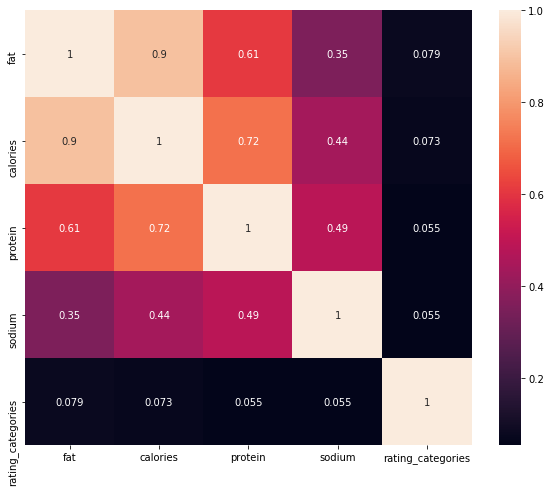

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_recipe[['fat','calories','protein','sodium', 'rating_categories']].corr(), annot=True)
plt.show()

As we can see from the correlaton matrix shown above, some of our predictors are quite correlated with each other (e.g. 'fat' and 'calories' which have correlation coefficient of 0.9), however, unfortunately, our predictors have almost 0 correlation with target, namely 'rating_categories', variable. This is of course undesirable and is a sign that we cannot expect to get good predictive model.

In [47]:
# Split the data with following proportions: 80% train, 10% test, 10% validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [48]:
X_train.shape,X_test.shape,X_val.shape

((4000, 4), (500, 4), (500, 4))

We will try to train a logistic regression model to predict the rating category for dishes.

In [49]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [50]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.5920 | Validation accuracy 0.5900 | Test accuracy 0.5800


Now we will apply graph filters to enhance our features.

In [52]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    eig_val, eig_vec = np.linalg.eigh(laplacian)
    idx = eig_val.argsort() 
    lamb = eig_val[idx]
    U = eig_vec[:,idx]
    return lamb,U

First, let's compute the Laplacian of the adjacency matrix and perform spectral decomposition.

In [53]:
laplacian = csgraph.laplacian(adjacency_matrix,normed=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

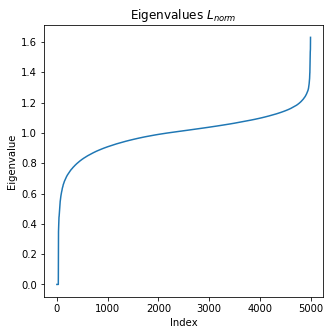

In [54]:
plt.figure(figsize=(5,5))
plt.plot(lam)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

We will vizualise some of the eigenvectors as signals on our graph.

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-1.0822405356506495,
 1.0524875063041834,
 -1.028135824411587,
 1.1070090415174525)

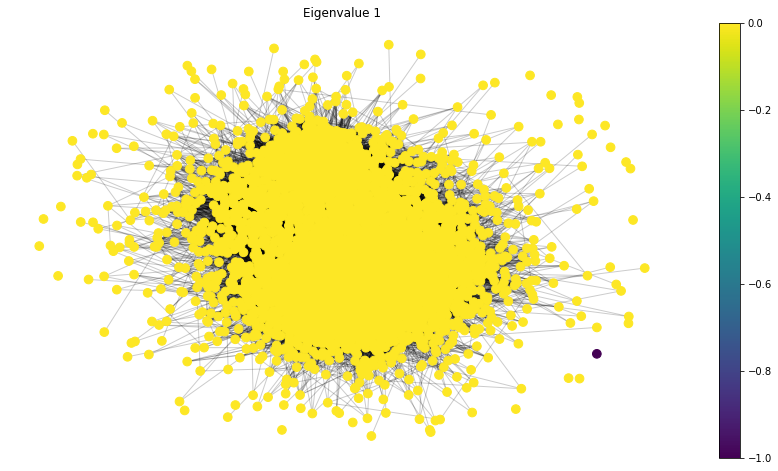

In [55]:
plt.figure(figsize=(15,8))
plt.title('Eigenvalue 1')
pos = nx.spring_layout(graph, k=0.1)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes(), node_color=U[:,1], node_shape='.')
plt.colorbar(nc)
plt.axis('off')

(-1.025984739098945, 1.0876252401212838, -1.10700236877747, 1.0279943855697673)

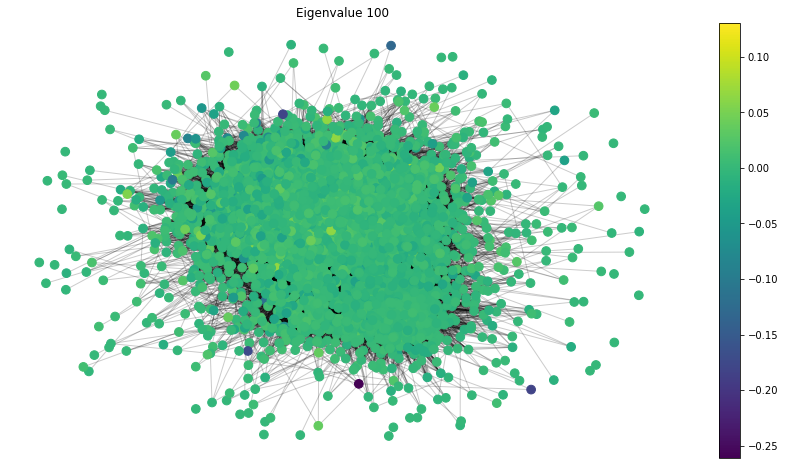

In [56]:
plt.figure(figsize=(15,8))
plt.title('Eigenvalue 100')
pos = nx.spring_layout(graph, k=0.1)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes(), node_color=U[:,100], node_shape='.')
plt.colorbar(nc)
plt.axis('off')

(-1.0593630719522622,
 1.0979191708902505,
 -1.1071565212900203,
 1.0312315883333247)

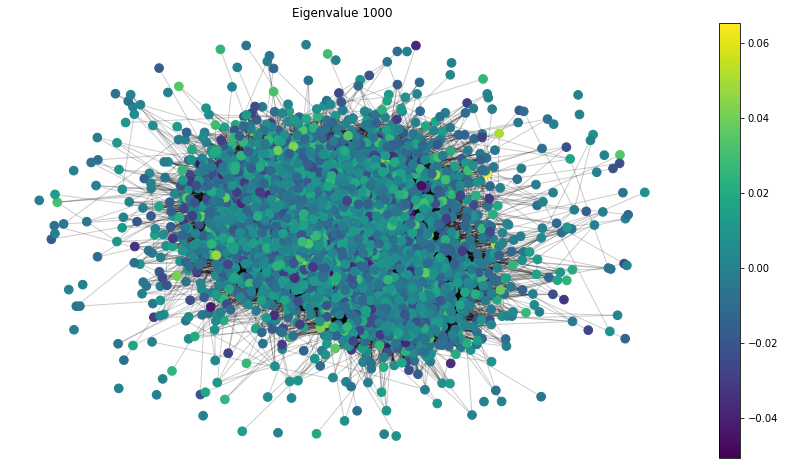

In [57]:
plt.figure(figsize=(15,8))
plt.title('Eigenvalue 1000')
pos = nx.spring_layout(graph, k=0.1)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes(), node_color=U[:,1000], node_shape='.')
plt.colorbar(nc)
plt.axis('off')

We can notice that there is a lot of noise in the higher eigenvalues. Let's apply an ideal lowpass filter to remove the noise in the features.

In [58]:
ideal_filter = np.ones((5000,))
ideal_filter[lam >= 0.1] = 0

Let's also try to approximate the filters with polynomials

In [59]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    V = np.vander(lam,N=order,increasing=True)
    return np.linalg.lstsq(V,spectral_response)[0]

In [60]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    V = np.vander(lam,N=coeff.shape[0],increasing=True)
    return np.dot(V,coeff)

In [61]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    L_k = [np.linalg.matrix_power(laplacian,k) for k in range(len(coeff))]
    res = np.zeros(laplacian.shape)
    for index,each in enumerate(L_k):
        res+=coeff[index]*each
    return res

In [62]:
order = 7

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Spectral response')

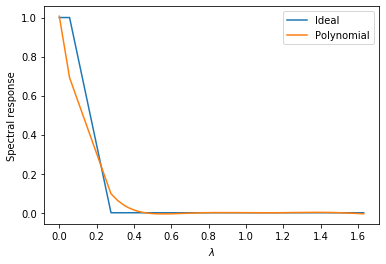

In [63]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

Let's now extract the new features after applying the polynomial graph filter

In [64]:
new_features = graph_filter @ features

X_train, X_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [65]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [66]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.5923 | Validation accuracy 0.5900 | Test accuracy 0.5820


We can notice that our accuracies almost have not improved. This can be explained by both the imbalance in the dataset but most importantly by the correlation matrix. 

Let's also take a look at the confusion matrix.

In [69]:
confusion_matrix(y_test,model_logit_best.predict(X_test),labels=[0, 1, 2])

array([[  0,   0,  31],
       [  0,   1, 178],
       [  0,   0, 290]])

As we know, most dishes have high rating and therefore the number of data points belonging to cluster 0 are much less compared to the ones in clusters 1 and 2. This is why explains our model always trues to predict the dishes to have good ratings, as we can observe from the confusion matrix (our model almost always predicts 2 - the class that has the largest share of datapoints)